### Clustering Models

In [40]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from pyclustering.cluster.kmedoids import kmedoids
from pyclustering.cluster.center_initializer import kmeans_plusplus_initializer
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster



In [3]:
df = pd.read_csv(
    'marketing_campaign.csv',
    sep='\t',
    parse_dates=['Dt_Customer'],  # if your date column is named differently, change this
    dayfirst=True                # set False if your dates are MM-DD-YYYY
)

In [5]:
df.head(3)

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response,Age
0,5524,1957,Graduation,Single,58138.0,0,0,2012-09-04,58,635,...,0,0,0,0,0,0,3,11,1,68
1,2174,1954,Graduation,Single,46344.0,1,1,2014-03-08,38,11,...,0,0,0,0,0,0,3,11,0,71
2,4141,1965,Graduation,Together,71613.0,0,0,2013-08-21,26,426,...,0,0,0,0,0,0,3,11,0,60


In [4]:
df['Age'] = 2025 - df['Year_Birth']

In [6]:
df['TenureDays'] = (pd.Timestamp('2025-06-14') - df['Dt_Customer']).dt.days


In [7]:
df.head(3)

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response,Age,TenureDays
0,5524,1957,Graduation,Single,58138.0,0,0,2012-09-04,58,635,...,0,0,0,0,0,3,11,1,68,4666
1,2174,1954,Graduation,Single,46344.0,1,1,2014-03-08,38,11,...,0,0,0,0,0,3,11,0,71,4116
2,4141,1965,Graduation,Together,71613.0,0,0,2013-08-21,26,426,...,0,0,0,0,0,3,11,0,60,4315


In [9]:
cat_cols = ['Education', 'Marital_Status']
df_cat = pd.get_dummies(df[cat_cols], drop_first=True)

In [11]:
num_cols = df.select_dtypes(include='number').columns.drop(['ID', 'Year_Birth'])
df_num = df[num_cols].fillna(0)

In [12]:
# Final feature matrix
X = pd.concat([df_num, df_cat], axis=1)

In [13]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


In [14]:
pca = PCA(n_components=2, random_state=42)
X_2d = pca.fit_transform(X_scaled)


In [29]:
def plot_labels(X_2d, labels, title):
    plt.figure(figsize=(6,5))
    plt.scatter(
        X_2d[:,0], X_2d[:,1],
        c=labels, cmap='inferno',
        edgecolor='k', alpha=0.7
    )
    plt.title(title)
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.grid(linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()


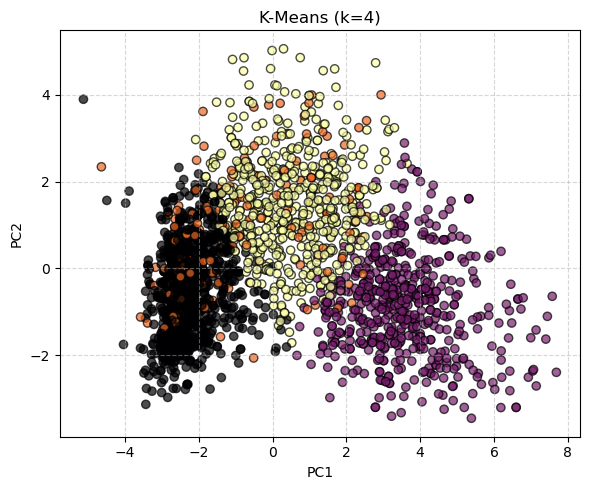

In [30]:
km = KMeans(n_clusters=4, random_state=42)
labels_km = km.fit_predict(X_scaled)
plot_labels(X_2d, labels_km, 'K-Means (k=4)')

In [34]:
import warnings
import numpy as np
np.warnings = warnings

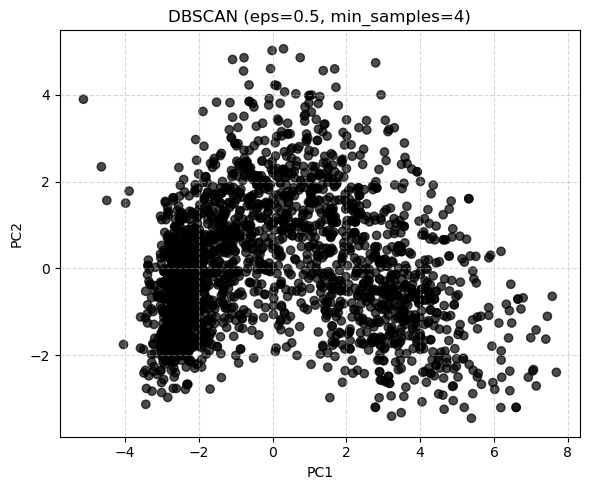

In [36]:
# C) DBSCAN
db = DBSCAN(eps=0.5, min_samples=5)
labels_db = db.fit_predict(X_scaled)
plot_labels(X_2d, labels_db, 'DBSCAN (eps=0.5, min_samples=4)')



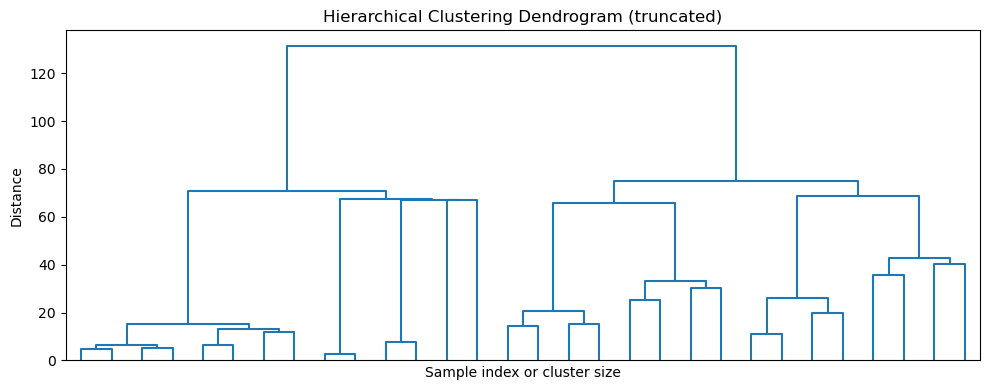

In [42]:
Z = linkage(X_scaled, method='ward')  # or 'complete', 'average', etc.

plt.figure(figsize=(10, 4))
dendrogram(Z, no_labels=True, color_threshold=0.0, truncate_mode='level', p=4)
plt.title('Hierarchical Clustering Dendrogram (truncated)')
plt.xlabel('Sample index or cluster size')
plt.ylabel('Distance')
plt.tight_layout()
plt.show()

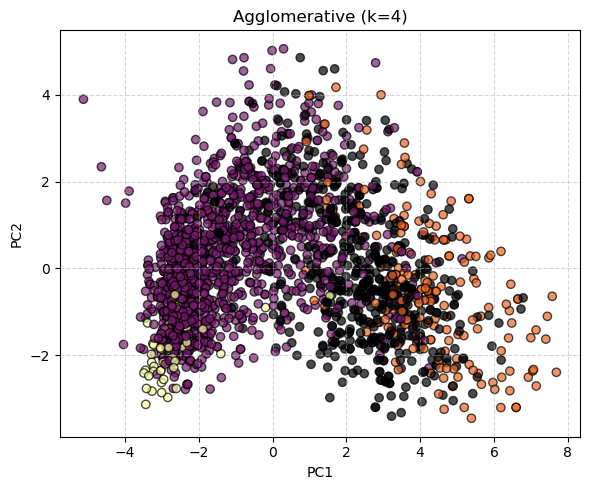

In [37]:
# D) Agglomerative (k=4)
agg = AgglomerativeClustering(n_clusters=4)
labels_agg = agg.fit_predict(X_scaled)
plot_labels(X_2d, labels_agg, 'Agglomerative (k=4)')

In [38]:
import skfuzzy as fuzz 

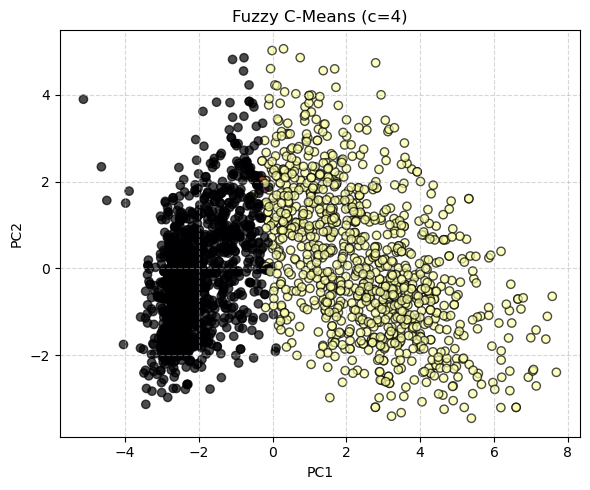

In [39]:
cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(
    X_scaled.T,              # data
    c=4,                     # number of clusters
    m=2.0,                   # fuzziness parameter
    error=0.005,             # stopping criterion
    maxiter=1000,            # max iterations
    init=None,               # use random init
    seed=42
)
# u[i, j] = membership of sample j to cluster i
labels_fuzzy = np.argmax(u, axis=0)
plot_labels(X_2d, labels_fuzzy, 'Fuzzy C-Means (c=4)')